In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import seaborn as sb

In [3]:
import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [4]:
from scipy.sparse import dok_matrix, csr_matrix

In [5]:
tr = pd.read_csv('../data/train.csv')
tr.head(5)

,mid,radiant_won
0,44380,1
1,19687,1
2,10801,0
3,32220,1
4,23207,1


In [6]:
ts = pd.read_csv('../data/test.csv')
ts.head(5)

,mid
0,36193
1,7390
2,1018
3,2960
4,27102


In [7]:
hr = pd.read_csv('../data/heroes.csv')
hr.head(5)

,mid,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9
0,0,91,42,87,15,65,11,6,34,69,74
1,1,69,85,71,24,64,74,68,39,65,11
2,2,17,40,31,67,99,32,7,72,48,104
3,4,25,15,75,29,95,3,32,55,64,86
4,5,65,6,81,25,71,75,42,101,96,109


In [8]:
hrtr = pd.merge(tr, hr, on = 'mid')
hrts = pd.merge(ts, hr, on = 'mid')

In [9]:
hrtr.head(5)

,mid,radiant_won,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9
0,44380,1,76,96,92,72,64,15,86,75,29,11
1,19687,1,1,64,90,29,11,71,101,74,86,66
2,10801,0,35,75,41,110,19,7,69,86,11,72
3,32220,1,106,11,76,6,77,104,18,96,64,55
4,23207,1,8,75,1,88,69,11,39,82,24,55


In [10]:
hrts.head(5)

,mid,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9
0,36193,64,50,3,75,71,81,90,92,44,94
1,7390,3,1,89,15,64,26,14,33,87,86
2,1018,61,96,13,82,32,102,28,90,107,46
3,2960,27,3,101,15,44,20,21,90,5,29
4,27102,15,101,69,3,104,49,66,67,81,16


In [11]:
radt = ['player_{i}'.format(i = i) for i in range(0, 5)]
dire = ['player_{i}'.format(i = i) for i in range(5, 10)]

In [12]:
cmnd = [*radt, *dire]

In [13]:
nheroes = len(np.unique(hrtr[cmnd].to_numpy()))
nheroes

111

In [14]:
def to_csr(data, nheroes = None):
    nhrs = len(np.unique(hrtr[cmnd].to_numpy())) if nheroes is None else nheroes
    nrows, ncols = data[cmnd].shape
    dradt, ddire = data[radt].to_numpy(), data[dire].to_numpy()
    mod_data = np.hstack((dradt, ddire + nhrs))
    frows = np.repeat(data.index.to_numpy(), ncols)
    fcols = mod_data.reshape(ncols * nrows)
    return csr_matrix((np.ones(ncols * nrows, dtype = np.float32), (frows, fcols)))

In [15]:
csr_hrtr, csr_hrts = to_csr(hrtr), to_csr(hrts)

In [16]:
hrtr_res = hrtr['radiant_won']

In [22]:
res = []
ks = [*range(2, 50, 1)]
for k in ks:
    def weights(distances):
        res = np.ones(distances.shape)
        #not to take into account the point itself
        res[:, 0] = 0.
        return res
    model = KNeighborsClassifier(algorithm = 'brute', n_jobs = 15, n_neighbors = k, weights = weights)
    model.fit(csr_hrtr, hrtr_res)
    pr = model.predict(csr_hrtr)
    res.append(roc_auc_score(hrtr_res, pr))

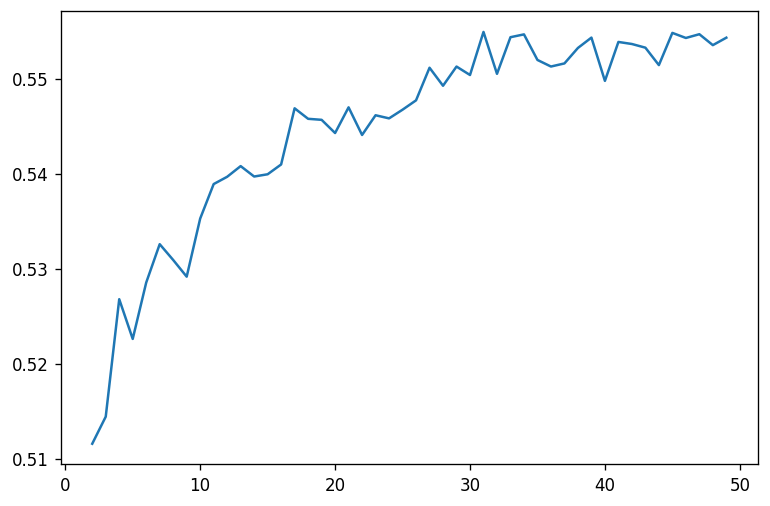

In [23]:
plt.figure(figsize = (7.5, 5.), dpi = 120)
plt.plot(ks, res)

In [24]:
max(res)

0.5549048858769744

In [25]:
np.argmax(res)

29

In [26]:
ks[np.argmax(res)]

17

In [17]:
border = 12000
train_data, train_labels = csr_hrtr[:border, :], hrtr_res[:border]
test_data, test_labels = csr_hrtr[border:, :], hrtr_res[border:]

In [22]:
res = []
ks = [*range(2, 100, 1)]
for k in ks:
    def weights(distances):
        res = np.ones(distances.shape)
        #not to take into account the point itself
        res[:, 0] = 0.
        return res
    model = KNeighborsClassifier(algorithm = 'brute', n_jobs = 16, n_neighbors = k, weights = weights)
    model.fit(train_data, train_labels)
    pr = model.predict(test_data)
    res.append(roc_auc_score(test_labels, pr))
    print(k, res[-1])

2 0.5132601644903303
3 0.5150389615534918
4 0.5255501169656991
5 0.5232751836424505
6 0.5314645834346315
7 0.5304948216340621
8 0.5318526682406162
9 0.5324982756788782
10 0.5320831780093681
11 0.5287398859336816
12 0.5218498048770825
13 0.5305393928588794
14 0.523224759630536
15 0.5373876039770138
16 0.5339407625911459
17 0.5375600360891857
18 0.5298208506890981
19 0.5375699408058117
20 0.5344017821286497
21 0.5378270132236971
22 0.5357137068672102
23 0.5412851099693675
24 0.5361913843372214
25 0.5381205530073422
26 0.5384685687324304
27 0.537359240470312
28 0.5465971895816788
29 0.5450781662227553
30 0.5470433520442435
31 0.5408952243058145
32 0.5435271776419931
33 0.5427843238950388
34 0.5385415034639495
35 0.5385333996048918
36 0.5410077779038378
37 0.5399763367315515
38 0.5422566726275052
39 0.5432403910742296
40 0.5371399860613624
41 0.5455756531260185
42 0.5422566726275052
43 0.5435024158504279
44 0.5442718322465158
45 0.5450763653651869
46 0.5496190285814104
47 0.553971251109778

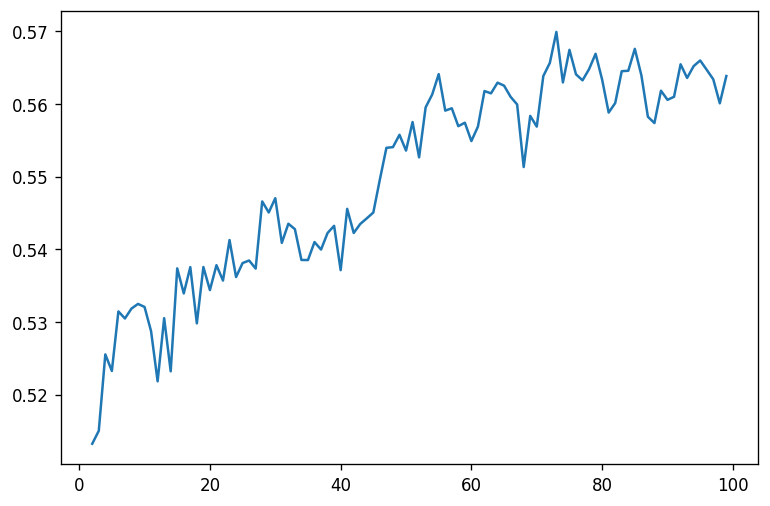

In [23]:
plt.figure(figsize = (7.5, 5.), dpi = 120)
plt.plot(ks, res)

In [25]:
np.argmax(res), ks[np.argmax(res)], res[np.argmax(res)]

(71, 73, 0.5699182950921229)